In [1]:
%matplotlib inline

# 잘못된 분석 사례

In [2]:
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline


In [3]:
def print_result(grid_model, X_train, X_test, y_train, y_test):
    print('교차검증 점수: ', grid_model.best_score_)
    print('최적의 하이퍼파라미터 조합: ', grid_model.best_params_)

    model = grid_model.best_estimator_

    print('학습평가: ', model.score(X_train, y_train))
    print('테스트평가: ', model.score(X_test, y_test))

    predict = model.predict(X_test)

    print('테스트 데이터에 대한 정밀도, 재현율, F1-score : \n', 
        classification_report(y_test, predict))

In [4]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    random_state=1, stratify=cancer.target)
scaler = MinMaxScaler()
base_model = SVC(random_state=1)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [5]:
X_train_scaled = scaler.fit_transform(X_train)

param_grid = { 'C':[0.001, 0.01, 0.1, 1, 5, 7, 10],
              'gamma':[0.0001, 0.001, 0.01, 0.1],
              'degree':[1,2,3,10]}

grid_model = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=kfold, n_jobs=1)
grid_model.fit(X_train_scaled, y_train)

print('교차검증 점수: ', grid_model.best_score_)
print('최적의 하이퍼파라미터 조합: ', grid_model.best_params_)

교차검증 점수:  0.9788235294117648
최적의 하이퍼파라미터 조합:  {'C': 7, 'degree': 1, 'gamma': 0.1}


# 올바른 분석 사례

In [6]:
pipe=Pipeline([('scaler', scaler), ('base_model', base_model)])

param_grid = { 'base_model__C':[0.001, 0.01, 0.1, 1, 5, 7, 10],
              'base_model__gamma':[0.0001, 0.001, 0.01, 0.1],
              'base_model__degree':[1,2,3,10]}

grid_model = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=kfold, n_jobs=1)
grid_model.fit(X_train, y_train)

print('교차검증 점수: ', grid_model.best_score_)
print('최적의 하이퍼파라미터 조합: ', grid_model.best_params_)

교차검증 점수:  0.9811764705882353
최적의 하이퍼파라미터 조합:  {'base_model__C': 7, 'base_model__degree': 1, 'base_model__gamma': 0.1}



# Pipelining: chaining a PCA and a logistic regression

The PCA does an unsupervised dimensionality reduction, while the logistic
regression does the prediction.

We use a GridSearchCV to set the dimensionality of the PCA


원본 데이터의 형태 :  (1797, 64) (1797,)
Best parameter (CV score=0.924):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 55}


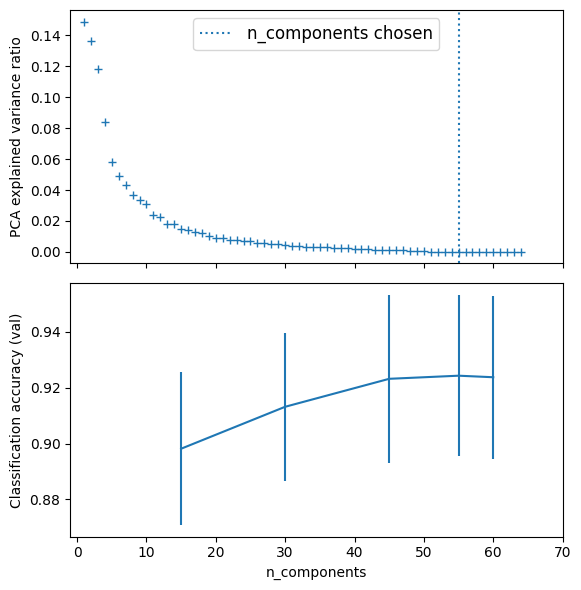

In [10]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=1000, tol=0.1)


pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])


X_digits, y_digits = datasets.load_digits(return_X_y=True)
print('원본 데이터의 형태 : ', X_digits.shape, y_digits.shape)

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [15, 30, 45, 55, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

In [8]:
X_digits.shape

(1797, 64)